# Random forest cross-validation (Ozone)

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import datetime

## Basis function construction

In [75]:
aq_df = pd.read_csv("./data/AQS/o3_data.csv")
print(aq_df.head())

   site.num   latitude   longitude parameter.name              day_time  \
0      2005  40.598056 -111.894167          Ozone  2023-01-01T00:00:00Z   
1      2005  40.598056 -111.894167          Ozone  2023-01-01T01:00:00Z   
2      2005  40.598056 -111.894167          Ozone  2023-01-01T02:00:00Z   
3      2005  40.598056 -111.894167          Ozone  2023-01-01T03:00:00Z   
4      2005  40.598056 -111.894167          Ozone  2023-01-01T04:00:00Z   

         date      hour  sample.measurement  
0  2023-01-01        0S               0.014  
1  2023-01-01  1H 0M 0S               0.007  
2  2023-01-01  2H 0M 0S               0.002  
3  2023-01-01  3H 0M 0S               0.009  
4  2023-01-01  4H 0M 0S               0.011  


In [76]:
## Time selection
# aq_df = aq_df[(aq_df.day_time >= "2023-01-08") & (aq_df.day_time <= "2023-01-14")]
aq_df = aq_df[aq_df.day_time <= "2023-01-14"]

In [77]:
grid_gdf = geopandas.read_file("./data/coarse_grid_pts/grid_pts_coarse.shp")

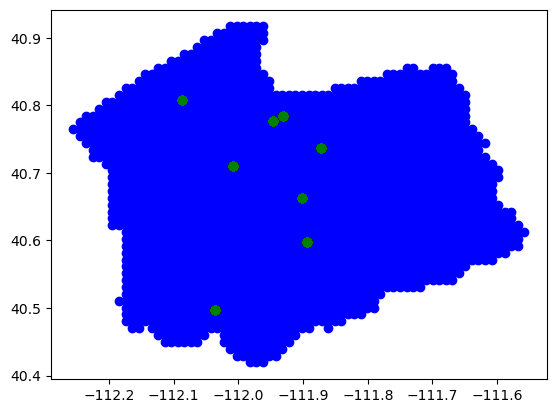

In [78]:
grid_crds = grid_gdf.get_coordinates()
plt.plot(grid_crds['x'], grid_crds['y'], 'bo')
plt.plot(aq_df['longitude'], aq_df['latitude'], 'go')

In [79]:
ebus = pd.read_csv("./data/EBUS_TEST_DATA/BUS04_2023_06.csv", header = [0,1],  
                 na_values = -9999.00)

### Get limits and standardize

In [80]:
min_x = grid_crds.x.min()
max_x = grid_crds.x.max()
min_y = grid_crds.y.min()
max_y = grid_crds.y.max()
print(min_x, max_x, min_y, max_y)

-112.25516635714284 -111.55831564285714 40.419293290000006 40.916769710000004


In [81]:
lon = aq_df.values[:,2].astype('float64')
lat = aq_df.values[:,1].astype('float64')
normalized_lon = (lon-min_x)/(max_x - min_x)
normalized_lat = (lat-min_y)/(max_y-min_y)
N = lon.shape[0]
print(N)

2480


In [82]:
day_time = aq_df['day_time']
day_time = pd.to_datetime(day_time)
# add the timezone:

print(day_time[0:10])
print(day_time.dtype)
day_time = day_time.astype('int64') / 1e9 ## Time in nanoseconds
min_t = day_time.min()
max_t = day_time.max()
print(min_t, max_t)

0   2023-01-01 00:00:00+00:00
1   2023-01-01 01:00:00+00:00
2   2023-01-01 02:00:00+00:00
3   2023-01-01 03:00:00+00:00
4   2023-01-01 04:00:00+00:00
5   2023-01-01 05:00:00+00:00
6   2023-01-01 06:00:00+00:00
7   2023-01-01 07:00:00+00:00
8   2023-01-01 08:00:00+00:00
9   2023-01-01 09:00:00+00:00
Name: day_time, dtype: datetime64[ns, UTC]
datetime64[ns, UTC]
1672531200.0 1673650800.0


In [83]:
aq_df['day_time2'] = (day_time - min_t) / (max_t-min_t)
aq_df['day_time2']

0        0.000000
1        0.003215
2        0.006431
3        0.009646
4        0.012862
           ...   
45645    0.987138
45646    0.990354
45647    0.993569
45648    0.996785
45649    1.000000
Name: day_time2, Length: 2480, dtype: float64

### Basis functions

#### Time

In [84]:
s = np.array(aq_df['day_time2']).reshape(len(aq_df),1)
print(s.shape)
N = len(aq_df)
print(N)

(2480, 1)
2480


We need to define:
- Number of basis layers (3)
- Number of knots per layer
- S.D. for Gaussian function

Then make a ragged array holding the knots on the normalized scale.

Note that one of the previous examples has a very high number of temporal knots (~800) which is very computationally expensive

In [85]:
## time basis 
num_basis = [10,15,45]
std_arr = [0.4,0.2,0.1]
num_basis = [10,20,56]
std_arr = [0.3,0.15,0.05]
#num_basis = [70,250,410]
#std_arr = [0.2,0.09,0.009]
#std_arr = [0.3,0.15,0.05]

mu_knots = [np.linspace(0,1,int(i)) for i in num_basis]

Now create the basis functions. This does the following:
- Loop over each basis layer
- Loop by knot in the selected layer
- Get distance from each observation (held in `s`) to the knot
- Estimate Gaussian weight

In [86]:
phi_t = np.zeros((N, sum(num_basis)))
K = 0
for res in range(len(num_basis)):
    std = std_arr[res]
    for i in range(num_basis[res]):
        d = np.square(np.absolute(s-mu_knots[res][i]))
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
            else:
                phi_t[j,i + K] = 0
    K = K + num_basis[res]

/var/folders/ws/m03sh3xd4ns621mckfrht3r0000_08/T/ipykernel_16805/420065419.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))


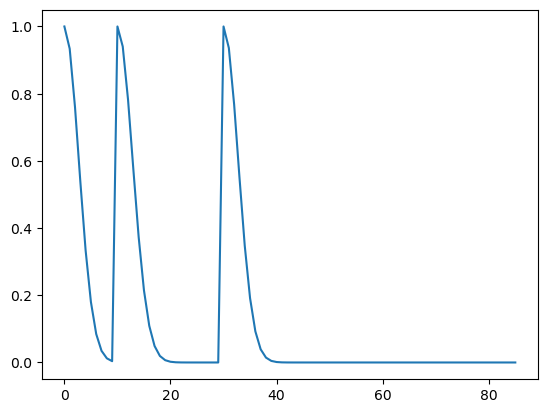

In [87]:
plt.plot(phi_t[0,:])
#plt.plot(phi_t[25000,:])
plt.show()

#### Space

In [88]:
s = np.vstack((normalized_lon,normalized_lat)).T

In [89]:
## Knots for spatial dimension (from STDK example)
num_basis = [5**2,9**2,11**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]

In [90]:
##Wendland kernel
K = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

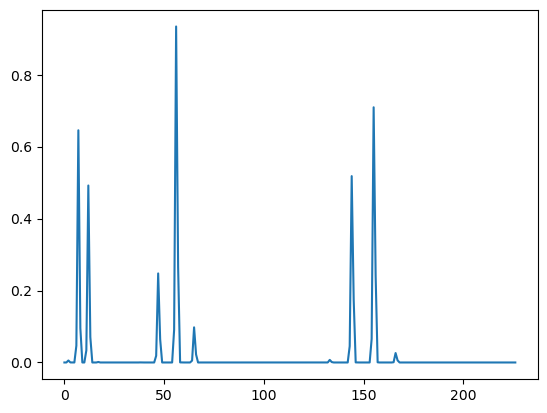

In [91]:
plt.plot(phi[0,:])

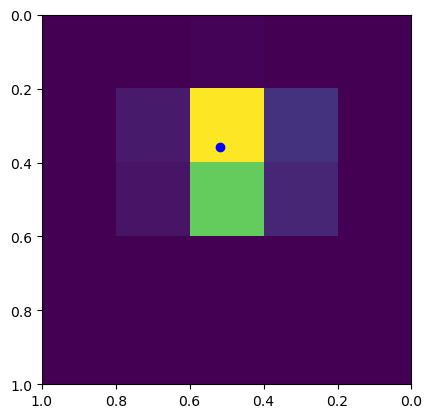

In [92]:
x = phi[0,0:25]
x = x.reshape(5, 5)
plt.imshow(x, extent=[1, 0, 1, 0])
plt.plot(normalized_lon[0], normalized_lat[0], 'bo')
plt.show()

#### Combine and reduce

In [93]:
print(phi_t.shape)
print(phi.shape)

phi2 = np.hstack((phi_t,phi))

(2480, 86)
(2480, 227)


In [94]:
idx_zero = np.array([], dtype=int)
for i in range(phi2.shape[1]):
    if sum(phi2[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

phi_reduce = np.delete(phi2,idx_zero,1)
print(phi2.shape)
print(phi_reduce.shape)

(2480, 313)
(2480, 217)


Make up as dataframe (this is just to keep code consistent)

In [95]:
dat = pd.DataFrame(phi_reduce)
dat['y'] = aq_df['sample.measurement'].to_numpy()
dat['site'] = aq_df['site.num'].to_numpy()
dat['date'] = aq_df['date'].to_numpy()

## Cross validation

Run cross validation by station (leave-one out)

In [96]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

In [107]:
dat.shape

(2480, 220)

In [97]:
#dat = pd.read_csv("./rbfs/phi_short_reduce.csv")
#dat.head()
#X = np.load("./rbfs/phi_reduce.npy")
#y = np.load("./rbfs/y.npy")

In [106]:
dat2 = dat[dat['date'] == "2023-01-01"]
dat2.shape

(191, 220)

In [99]:
dat2 = dat2.groupby('site')

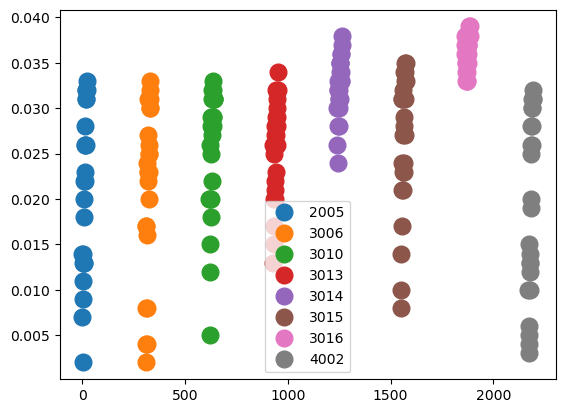

In [100]:
# Plot
fig, ax = plt.subplots()

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in dat2:
    ax.plot(group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [114]:
X = dat.iloc[:, 0:217]
y = dat['y']
groups = dat['site']
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

8

In [115]:
mygrps = groups.unique()
n_grps = len(mygrps)

In [116]:
X

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,216
0,1.000000,0.933712,0.760067,0.539408,0.333740,0.180022,0.084658,0.034709,0.012406,0.003866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.999943,0.937372,0.766082,0.545838,0.339062,0.183620,0.086694,0.035685,0.012806,0.004006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.999770,0.940938,0.772055,0.552282,0.344429,0.187269,0.088768,0.036684,0.013216,0.004151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.999483,0.944410,0.777986,0.558738,0.349842,0.190968,0.090882,0.037707,0.013639,0.004301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.999081,0.947785,0.783872,0.565205,0.355298,0.194718,0.093035,0.038753,0.014073,0.004456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,0.004456,0.014073,0.038753,0.093035,0.194718,0.355298,0.565205,0.783872,0.947785,0.999081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2476,0.004301,0.013639,0.037707,0.090882,0.190968,0.349842,0.558738,0.777986,0.944410,0.999483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2477,0.004151,0.013216,0.036684,0.088768,0.187269,0.344429,0.552282,0.772055,0.940938,0.999770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2478,0.004006,0.012806,0.035685,0.086694,0.183620,0.339062,0.545838,0.766082,0.937372,0.999943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cross-validation loop

In [117]:
my_mae = np.empty(n_grps)
my_y_true = []
my_y_pred = []

In [118]:
for i, (train_index, test_index) in enumerate(logo.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"Site {mygrps[i]}:")
    #print(f"  Train: index={train_index}, group={groups[train_index]}")
    #print(f"  Test:  index={test_index}, group={groups[test_index]}")

    # Split out data
    X_train = X.iloc[train_index, :]
    print(X_train.shape)
    y_train = y[train_index]
    n_feat = X_train.shape[1]
    
    X_test = X.iloc[test_index, :]
    print(X_test.shape)
    y_test = y[test_index]

    # Build model
    aq_rf = ensemble.RandomForestRegressor()

    # Train model
    aq_rf.fit(X_train, y_train)
    
    ## Predict for test set
    y_test_pred = aq_rf.predict(X_test)
    my_mae[i] = mean_absolute_error(y_test, y_test_pred)
    print(f"MAE: {my_mae[i]}")
    
    my_y_true.append(y_test.to_numpy())
    my_y_pred.append(y_test_pred)


Fold 0:
Site 2005:
(2171, 217)
(309, 217)
MAE: 0.005805760517799343
Fold 1:
Site 3006:
(2170, 217)
(310, 217)
MAE: 0.004671483870967745
Fold 2:
Site 3010:
(2170, 217)
(310, 217)
MAE: 0.0033627096774193513
Fold 3:
Site 3013:
(2169, 217)
(311, 217)
MAE: 0.01141247588424438
Fold 4:
Site 3014:
(2169, 217)
(311, 217)
MAE: 0.006635112540192933
Fold 5:
Site 3015:
(2169, 217)
(311, 217)
MAE: 0.0034595498392283007
Fold 6:
Site 3016:
(2172, 217)
(308, 217)
MAE: 0.005621558441558438
Fold 7:
Site 4002:
(2170, 217)
(310, 217)
MAE: 0.003729129032258061


In [119]:
print(my_mae)
print(np.mean(my_mae))

[0.00580576 0.00467148 0.00336271 0.01141248 0.00663511 0.00345955
 0.00562156 0.00372913]
0.005587222475458569


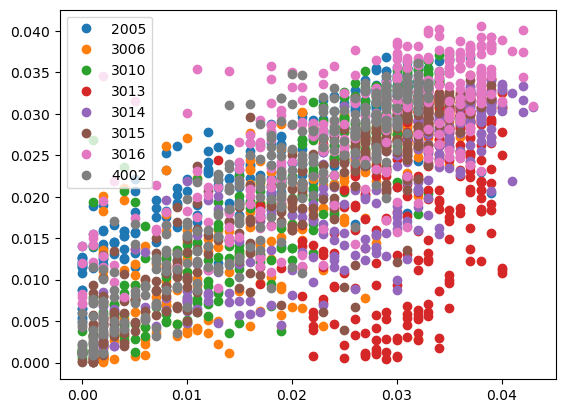

In [121]:
plt.figure()
for i in range(len(mygrps)):
    plt.plot(my_y_true[i], my_y_pred[i], 'o', label = mygrps[i])

plt.legend()
plt.show()

In [122]:
mygrps

array([2005, 3006, 3010, 3013, 3014, 3015, 3016, 4002])

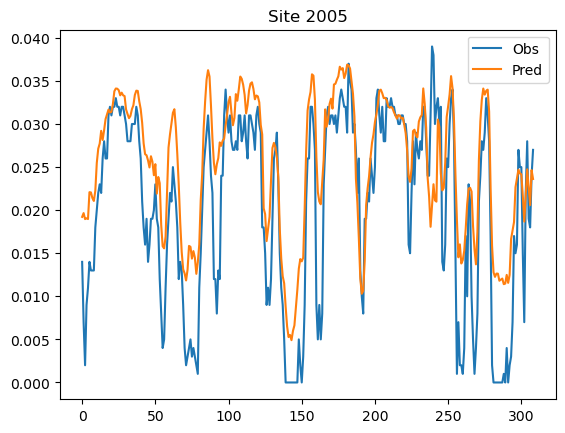

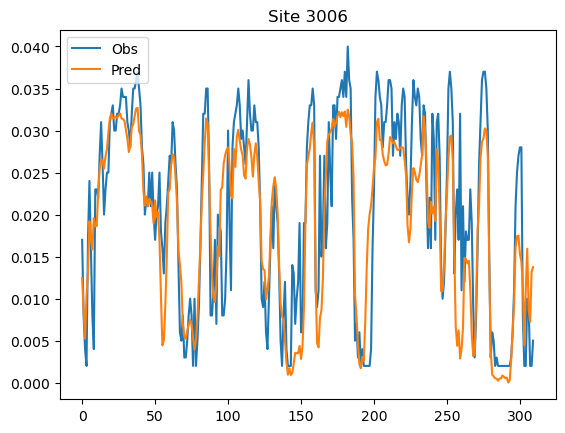

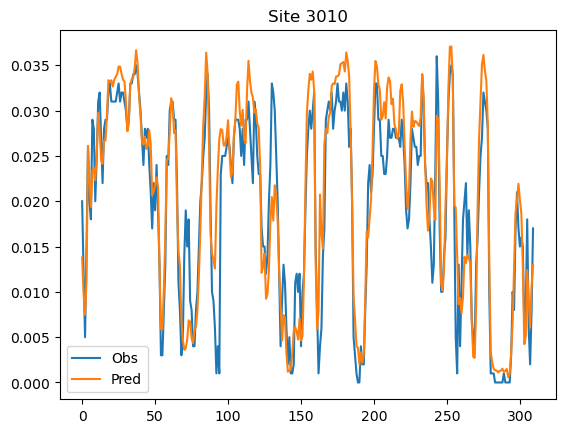

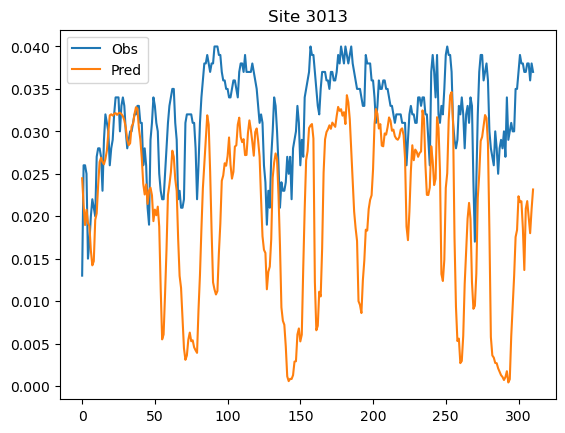

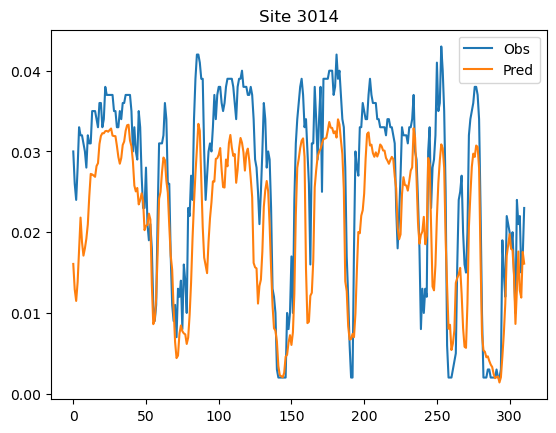

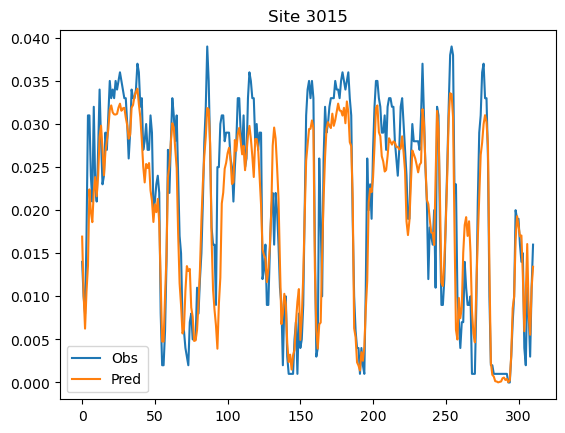

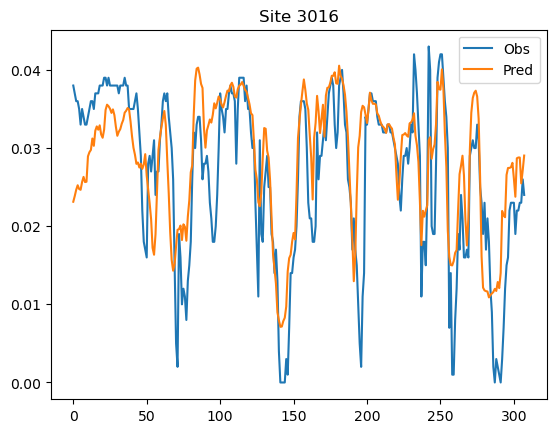

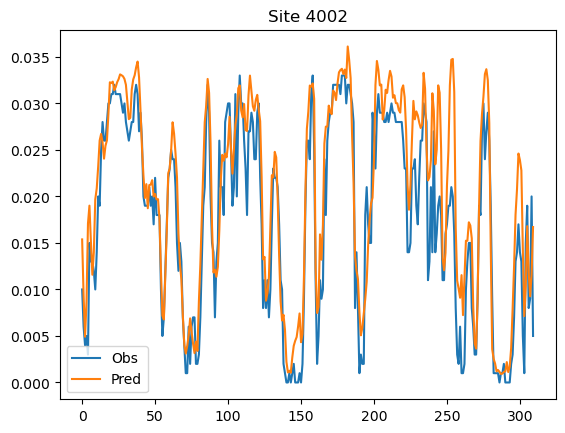

In [123]:
for i in range(len(mygrps)):
    plt.plot(my_y_true[i], label = "Obs")
    plt.plot(my_y_pred[i], label = "Pred")
    plt.title("Site " + mygrps[i].astype('str'))
    plt.legend()
    plt.show()